In [7]:
import os 
import os.path as osp 
from glob import glob
import cv2 
import numpy as np

working_dir = '/content/drive/My Drive/Challenges/MediaEval2020_Medico/medico'
os.chdir(working_dir)

In [9]:
DATA_DIR = 'data/Kvasir-SEG'
CUSTOM_DATA_DIR = 'custom_data'
DFS_MASKS_DIR = osp.join(CUSTOM_DATA_DIR, 'dfs_masks')
IMAGES_DIR = osp.join(DATA_DIR, 'images')
MASKS_DIR = osp.join(DATA_DIR, 'masks')
BBOXES_JSON = osp.join(DATA_DIR, 'kavsir_bboxes.json')

os.makedirs(DFS_MASKS_DIR, exist_ok=True)

In [4]:
!cp -r '/content/drive/My Drive/Challenges/MediaEval2020_Medico/medico/data/Kvasir-SEG/images' '/content/drive/My Drive/Challenges/MediaEval2020_Medico/medico/custom_data'

In [ ]:
from PIL import Image

from torch.utils.data import Dataset
from skimage import io
import torch 
from torchvision import transforms

## Test images

In [ ]:
sample_img_dir = glob(IMAGES_DIR+'/*.jpg')[0]

pil_img = Image.open(sample_img_dir)
cv_img = cv2.imread(sample_img_dir)

print(pil_img.size) # width, height
print(cv_img.shape) # height, width, channel

(622, 530)
(530, 622, 3)


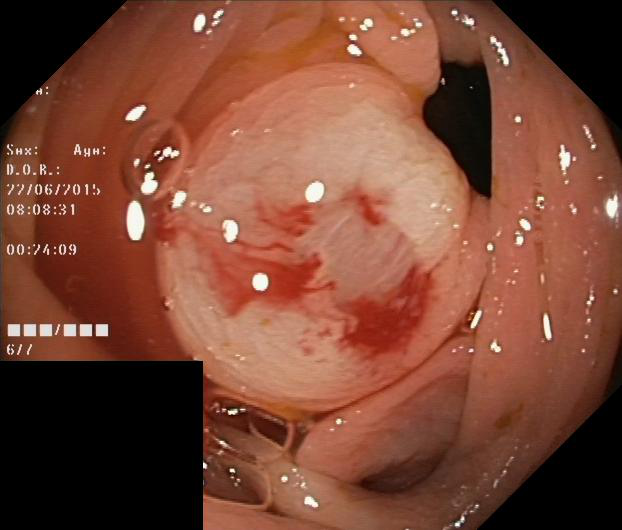

In [ ]:
display(pil_img)

In [ ]:
pil_tensor = transforms.functional.to_tensor(pil_img)
cv_tensor = torch.from_numpy(cv_img)

print(pil_tensor.shape)
print(cv_tensor.shape)

torch.Size([3, 530, 622])
torch.Size([530, 622, 3])


In [ ]:
cv_tensor.unsqueeze(0).shape

torch.Size([530, 1, 570, 3])

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')   # 'cpu' in this case

a = pil_tensor.cuda()
b = pil_tensor.to(device)

print(type(a))
print(type(b))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
%cd Modules/ResUnet

/content/drive/My Drive/Challenges/MediaEval2020_Medico/Modules/ResUnet


In [ ]:
from core.res_unet_plus import ResUnetPlusPlus

In [ ]:
img = torch.ones(1, 3, 256, 256)
model = ResUnetPlusPlus(3)
output = model(img)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
img = torch.ones(1, 3, 494, 494)
output = model(img)
print(output.shape)

## Test masks

In [ ]:
sample_img = os.listdir(IMAGES_DIR)[0]
img_name = sample_img.split('.')[0]
sample_mask = os.path.join(MASKS_DIR, f"{img_name}.jpg")
sample_img = os.path.join(IMAGES_DIR, f"{img_name}.jpg")

cv_img = cv2.imread(sample_img, cv2.IMREAD_COLOR)
cv_mask = cv2.imread(sample_mask)
pil_img = Image.open(sample_img)
pil_mask = Image.open(sample_mask)

print(pil_img.size)
print(pil_mask.size)

(622, 530)
(622, 530)


In [ ]:
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow

def resize_img(img_array, target_size):
    res = cv2.resize(img_array, dsize=target_size, interpolation=cv2.INTER_CUBIC)
    return res

def show_mask(img_array, mask_array):
    gray_mask = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)
    gray_mask[gray_mask > 0] = 1
    img_array[np.nonzero(gray_mask)] = (0,255,0)
    return img_array 

def test_resize(img_array, mask_array, target_size):
    img = resize_img(img_array, target_size)
    mask = resize_img(mask_array, target_size)

    return show_mask(img, mask)



In [ ]:
raw_size = cv_img.shape
target_size= (raw_size[1]//2, raw_size[0]//2)

half_img_blend = test_resize(cv_img, cv_mask, target_size)

half_img = resize_img(cv_img, target_size)
half_mask = resize_img(cv_mask, target_size)

back_2_raw_img = test_resize(half_img, half_mask, (raw_size[1], raw_size[0]))

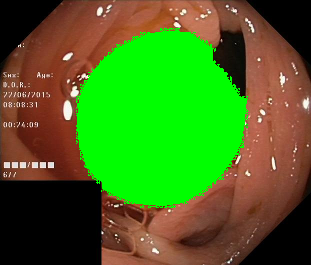

In [ ]:
cv2_imshow(half_img_blend)

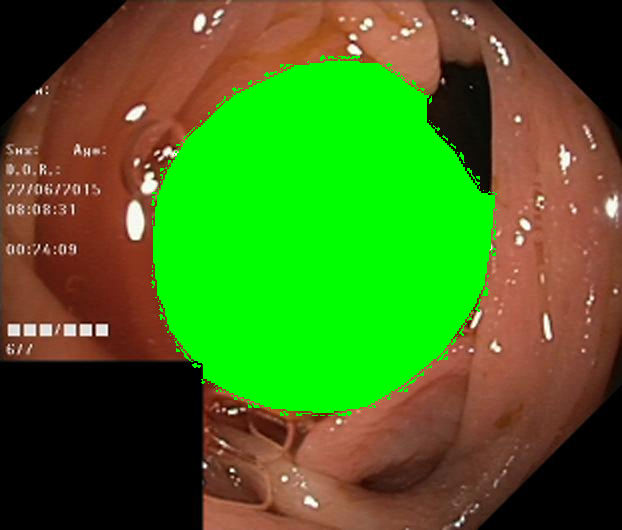

In [ ]:
cv2_imshow(back_2_raw_img)

In [ ]:
dx = [1, 0, -1, 0]
dy = [0, 1, 0, -1]

from tqdm.autonotebook import tqdm

def refine_mask(mask_array):
    HEIGHT, WIDTH = mask_array.shape[:2]
    gray_mask = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)
    init_mask_ids = np.nonzero(gray_mask)
    
    visited = np.zeros(gray_mask.shape)

    root_path = []
    root_point = None

    def dfs(x, y):
        if visited[x, y] == 1:
            return []
        queue = []
        path = []
        start = (x, y)
        queue.append(start)
        path.append((y,x))
        visited[y, x] = 1
        while len(queue) > 0:
            point = queue.pop(0)
            
            for k in range(4):  
                next_x = point[0]+dx[k]
                next_y = point[1]+dy[k]
                if next_x < 0 or next_x >= WIDTH or next_y < 0 or next_y >= HEIGHT:
                    continue
                if visited[next_y, next_x] == 0 and gray_mask[next_y,next_x] > 0:
                    queue.append((next_x, next_y))
                    visited[next_y, next_x] = 1
                    path.append((next_y, next_x))


        return path

    max_dist = 0
    list_points = np.array(init_mask_ids).T 
    print(list_points.shape)
    for point in tqdm(list_points):
        path = dfs(point[1], point[0])
        if len(path) > max_dist:
            root_point = (point[0], point[1])
            root_path = path
            max_dist = len(path)
    
    
    refine_ids = np.array(root_path).T
    print(refine_ids)
    res = np.zeros(gray_mask.shape)
    res[refine_ids] = 1
    return res, refine_ids


In [ ]:
new_mask, refine_ids = refine_mask(cv_mask)

(91685, 2)



[[ 58  59  59 ... 377 376 378]
 [337 337 338 ... 205 204 205]]


In [ ]:
ids = np.nonzero(new_mask)
ids_t = np.array(ids).T

print(ids)
print(ids_t)

print(refine_ids)

(array([ 58,  58,  58, ..., 493, 493, 493]), array([  0,   1,   2, ..., 619, 620, 621]))
[[ 58   0]
 [ 58   1]
 [ 58   2]
 ...
 [493 619]
 [493 620]
 [493 621]]
[[ 58  59  59 ... 377 376 378]
 [337 337 338 ... 205 204 205]]


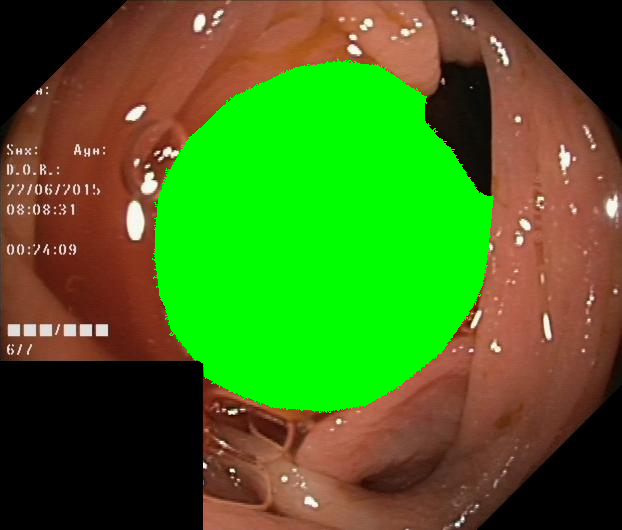

In [ ]:
tmp = np.array(cv_img, copy=True)
tmp[refine_ids[0], refine_ids[1], :] = (0, 255, 0)
cv2_imshow(tmp)

In [ ]:
gray_mask = cv2.cvtColor(cv_mask, cv2.COLOR_BGR2GRAY)
ids = np.nonzero(gray_mask)
ids_t = np.array(ids).T

print(ids)
print(ids_t)


(array([ 56,  56,  56, ..., 415, 415, 415]), array([323, 325, 329, ..., 344, 347, 349]))
[[ 56 323]
 [ 56 325]
 [ 56 329]
 ...
 [415 344]
 [415 347]
 [415 349]]


In [ ]:
print(len(refine_ids[0]))
print(len(ids[0]))

90347
271192


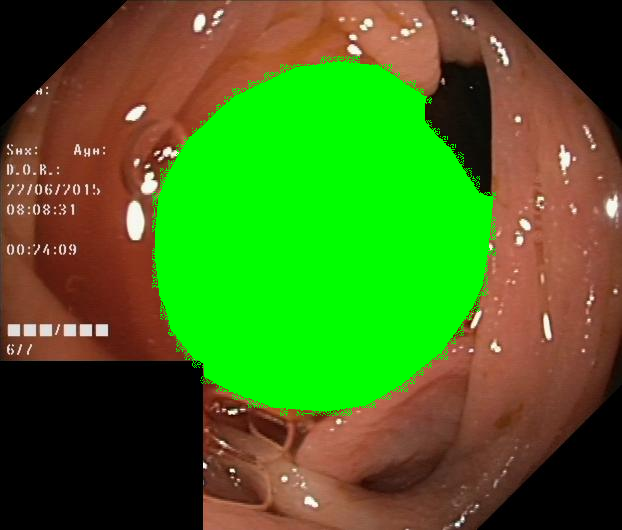

In [ ]:
tmp = np.array(cv_img, copy=True)
tmp[ids] = (0,255,0)
cv2_imshow(tmp)

In [ ]:
new_mask = refine_mask(cv_mask)
# tmp = cv_img
# tmp[np.nonzero(new_mask)] = (0,255,0)
# cv2_imshow(tmp)
# cv2_imshow(show_mask(cv_img, new_mask))

(91685, 2)



[[ 58  59  59 ... 377 376 378]
 [337 337 338 ... 205 204 205]]


In [ ]:
print(new_mask.shape)

(530, 622)


In [ ]:
print(np.nonzero(new_mask))

(array([ 58,  58,  58, ..., 493, 493, 493]), array([  0,   1,   2, ..., 619, 620, 621]))


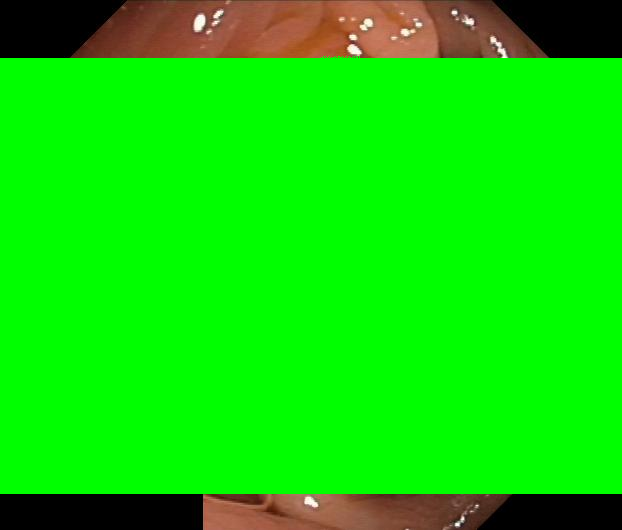

In [ ]:
tmp = cv_img
tmp[np.nonzero(new_mask)] = (0,255,0)
cv2_imshow(tmp)

(530, 622, 3)


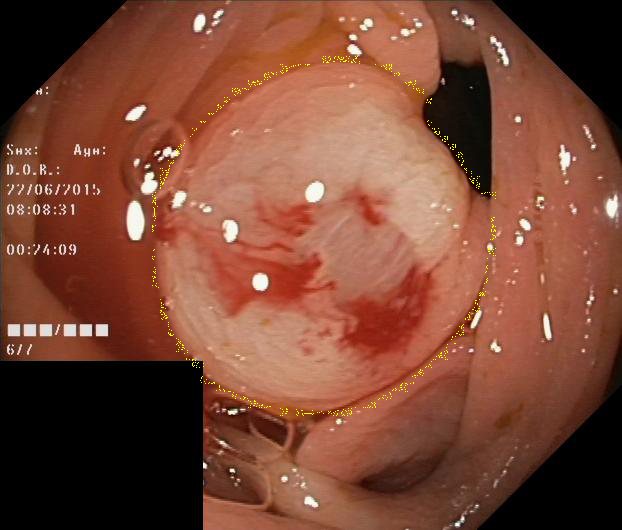

In [ ]:
from PIL import Image, ImageFilter

def drawContour(m,s,c,RGB):
    """Draw edges of contour 'c' from segmented image 's' onto 'm' in colour 'RGB'"""
    # Fill contour "c" with white, make all else black
    thisContour = s.point(lambda p:p==c and 255)
    # DEBUG: thisContour.save(f"interim{c}.png")

    # Find edges of this contour and make into Numpy array
    thisEdges   = thisContour.filter(ImageFilter.FIND_EDGES)
    thisEdgesN  = np.array(thisEdges)

    # Paint locations of found edges in color "RGB" onto "main"
    m[np.nonzero(thisEdgesN)] = RGB
    return m

# Load segmented image as greyscale
seg = pil_mask.convert('L')

# Load main image - desaturate and revert to RGB so we can draw on it in colour
main = pil_img.convert('RGB')
mainN = np.array(main)

mainN = drawContour(mainN,seg,1,(255,255,0))   # draw contour 1 in red
# mainN = drawContour(mainN,seg,2,(255,255,0)) # draw contour 2 in yellow

# Save result
print(mainN.shape)
display(Image.fromarray(mainN).convert('RGB'))

## Prepare dataset

In [48]:
dx = [1, 0, -1, 0]
dy = [0, 1, 0, -1]

from tqdm.autonotebook import tqdm

def refine_patch(mask_array):
    HEIGHT, WIDTH = mask_array.shape[:2]
    gray_mask = cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY)
    init_mask_ids = np.nonzero(gray_mask)

    visited = np.zeros(gray_mask.shape)

    root_path = []
    root_point = None

    def dfs(x, y):
        if visited[y, x] == 1:
            return []
        queue = []
        path = []
        start = (x, y)
        queue.append(start)
        path.append((y,x))
        visited[y, x] = 1
        while len(queue) > 0:
            point = queue.pop(0)
            
            for k in range(4):  
                next_x = point[0]+dx[k]
                next_y = point[1]+dy[k]
                if next_x < 0 or next_x >= WIDTH or next_y < 0 or next_y >= HEIGHT:
                    continue
                if visited[next_y, next_x] == 0 and gray_mask[next_y,next_x] > 0:
                    queue.append((next_x, next_y))
                    visited[next_y, next_x] = 1
                    path.append((next_y, next_x))


        return path

    max_dist = 0
    list_points = np.array(init_mask_ids).T 
    for point in list_points:
        path = dfs(point[1], point[0])
        if len(path) > max_dist:
            root_point = (point[0], point[1])
            root_path = path
            max_dist = len(path)
    
    
    refine_ids = np.array(root_path).T
    res = np.zeros(mask_array.shape)
    for point in root_path:
        res[point[0], point[1], :] = 255
    
    return res, refine_ids



def refine_mask(mask_array, list_bboxes: list):
    patches = []
    res = mask_array
    for box in list_bboxes:
        label, xmin, ymin, xmax, ymax = box.values()
        patch = mask_array[ymin:ymax+1, xmin:xmax+1, :]
        refined_patch, _ = refine_patch(patch)
        res[ymin:ymax+1, xmin:xmax+1, :] = refined_patch
    
    return res


In [49]:
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow
import json 
boxes_dict = json.load(open(BBOXES_JSON, 'r'))

mask_dir = MASKS_DIR
save_dir = DFS_MASKS_DIR

for mask in tqdm(os.listdir(mask_dir)):
    if '.jpg' not in mask: 
        continue
    mask_name = mask.split('.')[0]
    save_name = mask_name
    save_path = osp.join(save_dir, f"{mask_name}.jpg")
    cv_mask = cv2.imread(osp.join(mask_dir, mask))
    mask_boxes = boxes_dict[mask_name]['bbox']
    refined_mask = refine_mask(cv_mask, mask_boxes)
    assert refined_mask.shape == cv_mask.shape, f"Incompatible shape: before mask: {cv_mask.shape}, after mask: {refined_mask.shape}"
    cv2.imwrite(save_path, refined_mask)
    # cv2_imshow(refined_mask)
    # print(f"before mask: {cv_mask.shape}, after mask: {refined_mask.shape}")
